May 4: A closer look at the bathymetry of Mackenzie Canyon as depicted by the IBCAO_V3_500m_RR and IBCAO_V3_30arcsec_RR.

IBCAO_V3_500m_RR

* title: J:\jazz3\IBCAO_ASCII_INPUTDATA\ver3.0\\resamp_grd01.grd
* GMT_version: 4.5.8
* dimensions(sizes): x(11617), y(11617)
* variables(dimensions): float64 x(x), float64 y(y), float32 z(y,x)
 

* float64 x(x), actual_range: [-2904000.  2904000.], current shape = (11617,)
* float64 y(y), actual_range: [-2904000.  2904000.], current shape = (11617,)
* float32 z(y, x), actual_range: [-5573.01660156  5921.39746094], current shape = (11617, 11617)

IBCAO_V3_30arcsec_RR

* title: IBCAO_V3_30arcsec_RR.grd
* GMT_version: 4.5.8 [64-bit]
* dimensions(sizes): x(43201), y(3121)
* variables(dimensions): float64 x(x), float64 y(y), float32 z(y,x)


* "Geographic Coordinate System"

In [1]:
import  numpy as np
import  os
import  scipy as sc, scipy.io
import matplotlib.pyplot as plt
import  matplotlib.cm as cm
from mpl_toolkits.mplot3d import Axes3D
from    pyproj import Proj, Geod
import  cartopy.crs as ccrs
%matplotlib inline

In [2]:
def get_variables(ibcao_grid_name):
    ibcao_grid_dir = '/ocean/imachuca/Canyons/mackenzie_canyon/bathymetry/grid'
    ibcao_grid = os.path.join(ibcao_grid_dir, ibcao_grid_name)
    ibcao_nc = scipy.io.netcdf_file (ibcao_grid)

    x = ibcao_nc.variables['x'][:]
    y = ibcao_nc.variables['y'][:]
    z = ibcao_nc.variables['z'][:]
    return x, y, z

In [3]:
def Colormap():
    COLORMAP = """\
    # downloaded from IBCAO homepage
    #Discrete color table for Ocean and continous for land in RGB for the Arctic bathymetry and topography
    -6000	18	10	59	-5000	18	10	59
    -5000	22	44	103	-4000	22	44	103
    -4000	22	88	135	-3000	22	88	135
    -3000	22	138	170	-2000	22	138	170
    -2000	22	154	184	-1500	22	154	184
    -1500	23	170	198	-1000	23	170	198
    -1000	23	186	212	-500	23	186	212
    -500	24	196	223	-250	24	196	223
    -250	25	206	234	-100	25	206	234
    -100	27	216	245	-75	27	216	245
    -75	38	223	241	-50	38	223	241
    -50	49	230	236	-25	49	230	236
    -25	105	242	233	-10	105	242	233
    -10	161	255	230	0	161	255	230
    0	40	158	38	25	44	176	42
    25	44	176	42	50	49	195	46
    50	49	195	46	75	145	208	80
    75	145	208	80	100	242	202	90
    100	242	202	90	200	227	170	48
    200	227	170	48	300	190	140	40
    300	190	140	40	400	151	109	31
    400	151	109	31	500	114	80	23
    500	114	80	23	600	95	63	12
    600	95	63	12	700	81	57	16
    700	81	57	16	800	114	97	71
    800	114	97	71	1000	105	105	105
    1000	105	105	105	1500	170	170	170
    1500	170	170	170	5000	200	200	200
    """
    cmap = np.empty ((0,4))
    c = 0
    for l in COLORMAP.split("\n"):
      l = l.strip()
      if len(l) == 0 or l[0] == '#':
        continue
      ls = np.array([float (v) for v in l.split ()])
      if ls.shape[0] < 8:
        continue
      c += 1
      cmap.resize (c, 4)
      cmap[c-1,:] = ls[:4]
    c += 1
    cmap.resize (c, 4)
    cmap[c-1,:] = ls[4:]
    cmap[:,[1, 2, 3]] = cmap[:,[1, 2, 3]] / 255.
    cmap_out = cm.colors.ListedColormap (cmap[:,1:4], 'ibcao', c)
    norm     = cm.colors.BoundaryNorm (cmap[:,0], c)
    return (cmap_out, norm)

def get_cartopyS():
    m = ccrs.Stereographic(central_latitude=90, central_longitude=0, false_easting=0, false_northing=0, 
                           true_scale_latitude=75.0)
    return m

def get_cartopyG():
    # http://scitools.org.uk/cartopy/docs/v0.13/crs/projections.html ---- projections list
    m = ccrs.PlateCarree(central_longitude=0.0, globe=None)
    return m

In [30]:
def return_boundariesS(x, y, z, xl, xr, yb, yt, case):
    '''Extracts region from full bathymetry file.
    Stereographic projection IBCAO_V3_500m_RR.
    '''
    if case == 'region':
        xl=-1800000; xr=-700000; yb=1200000; yt=2000000
    elif case == 'canyon':
        xl=-1630000; xr=-1320000; yb=1560000; yt=1730000
    elif case == 'HS':
        xl=-1630000; xr=-1460000; yb=1600000; yt=1710000
    elif case == None:
        xl=xl; xr=xr; yb=yb; yt=yt
        
    xmin = np.where(x==xl)[0][0]
    xmax = np.where(x==xr)[0][0]
    ymin = np.where(y==yb)[0][0]
    ymax = np.where(y==yt)[0][0]
    xn = x[xmin:xmax]
    yn = y[ymin:ymax]
    zn = z[ymin:ymax, xmin:xmax]
    return xn, yn, zn

def return_boundariesG(x, y, z, xl, xr, yb, yt, case):
    '''Extracts region from full bathymetry file.
    Geographic projection IBCAO_V3_30arcsec_RR.
    '''
    if case == 'region':
        xl=-145; xr=-133; yb=68.6; yt=72.5
    elif case == None:
        xl=xl; xr=xr; yb=yb; yt=yt
        
    xmin = np.where(np.round(x,2)==xl)[0][0]
    xmax = np.where(np.round(x,2)==xr)[0][0]
    ymin = np.where(np.round(y,2)==yb)[0][0]
    ymax = np.where(np.round(y,2)==yt)[0][0]
    xn = x[xmin:xmax]
    yn = y[ymin:ymax]
    zn = z[ymin:ymax, xmin:xmax]
    return xn, yn, zn

def plot_mackenzie(ax, xn, yn, zn, plot_type):
    '''Plots canyon bathymetry using xn, yn, and zn
    for region specified in the return_boundaries function.
    '''
    (cmap, norm) = Colormap()
    if plot_type == 'full':
        c = ax.pcolorfast(xn,yn,zn,cmap=cmap)
        fig.colorbar(c)
    if plot_type == 'contour':
        cs = ax.contour(xn,yn,zn,100,linewidths=2,cmap=cmap)
        ax.clabel(cs, inline=1, fontsize=10)
        cb = fig.colorbar(cs)
        for line in cb.lines: 
           line.set_linewidth(12)
    if plot_type=='surface':
        Xn, Yn = np.meshgrid(xn, yn)
        surf = ax.plot_surface(Xn, Yn, zn, cmap=cmap, linewidth=0, rstride=1, cstride=1, antialiased=False)
        fig.colorbar(surf, shrink=0.5)
    return ax

In [54]:
x, y, z = get_variables('IBCAO_V3_500m_RR.grd')

/home/imachuca/anaconda3/lib/python3.5/site-packages/scipy/io/netcdf.py:297: RuntimeWarning: Cannot close a netcdf_file opened with mmap=True, when netcdf_variables or arrays referring to its data still exist. All data arrays obtained from such files refer directly to data on disk, and must be copied before the file can be cleanly closed. (See netcdf_file docstring for more information on mmap.)
  ), category=RuntimeWarning)


(<matplotlib.figure.Figure at 0x7f7c282ba438>,
 <cartopy.mpl.geoaxes.GeoAxesSubplot at 0x7f7c2680d4a8>)

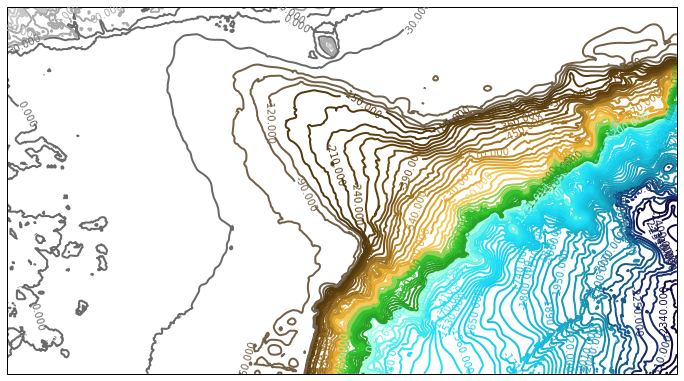

In [13]:
plt.figure(figsize=(12,12))
ax = plt.axes(projection=get_cartopyS())
xn, yn, zn = return_boundariesS(x, y, z, 0, 0, 0, 0, 'canyon')
plot_mackenzie(fig, ax, xn, yn, zn, 'contour')

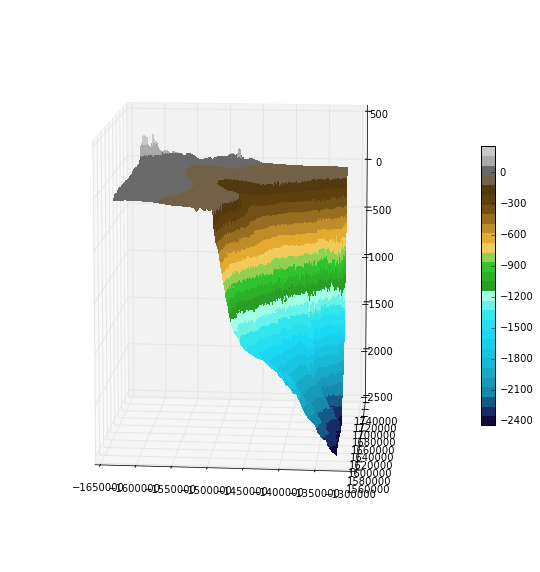

In [55]:
fig = plt.figure(figsize=(10,10))
ax = fig.gca(projection='3d')
xn, yn, zn = return_boundariesS(x, y, z, 0, 0, 0, 0, 'canyon')
ax = plot_mackenzie(ax, xn, yn, zn, 'surface')
ax.view_init(elev=10, azim=-85)

$H_D$ = maximum depth in domain: **600 m** (arbitrary)
* Depth at canyon mouth along axis: **378.29599 m**

$H_S$ = shelf depth: **80 m**. The stereographic plot for case HS shows the region near the shelf break along the eastern wall of the canyon. The contour and surface plots show that at 80 m, the bathymetry falls quickly.

$y_c$ = steepness of the continental slope: **0.00215** (west) and **0.00186** (east)
* Distance between west and middle: **70.23 km**
* Distance between middle and east: **81.32 km**
* Depth at west and east coordinate: **80 m**
* Depth at middle coordinate:  **231.473 m**

$y_n$ = distance between head and coast: **62.92 km** The geographic plot gives the coordinates of the head (80 m) and coastline (0 m) connected by the line segment running down the canyon axis.

$y_b$ = distance between head and shelf break: **91.92 km**

$x_0$ = location of axis:

$b$ = canyon width: **151.6 km**. The geographic plot allows to find the coordinates bounding the line segment that runs across the width of the canyon at its mid-length. This location was chosen to agree with the gaussian function for the idealized canyon.

http://www.movable-type.co.uk/scripts/latlong.html

In [109]:
HS = -80.0
yn = 62.92 * 1000
yb = 91.92 * 1000
b = 151.6 * 1000
yc_w = 0.0021568134301886434
yc_e = 0.0018626783964848554

In [155]:
# used to find yc_w and yc_e
mid_dep = z[np.where(np.round(y,2)==69.93)[0][0], np.where(np.round(x,2)==-138.45)[0][0]]
dif_dep = -1*(mid_dep - HS)
dist_w = 70.23*1000
dist_e = 81.32*1000

yc_w = dif_dep/dist_w
yc_e = dif_dep/dist_e

# depth at the point along the axis at the canyon mouth
dep_mouth = z[np.where(np.round(y,2)==70.2)[0][0], np.where(np.round(x,2)==-138.7)[0][0]]

In [57]:
x, y, z = get_variables('IBCAO_V3_30arcsec_RR.grd')

/home/imachuca/anaconda3/lib/python3.5/site-packages/scipy/io/netcdf.py:297: RuntimeWarning: Cannot close a netcdf_file opened with mmap=True, when netcdf_variables or arrays referring to its data still exist. All data arrays obtained from such files refer directly to data on disk, and must be copied before the file can be cleanly closed. (See netcdf_file docstring for more information on mmap.)
  ), category=RuntimeWarning)


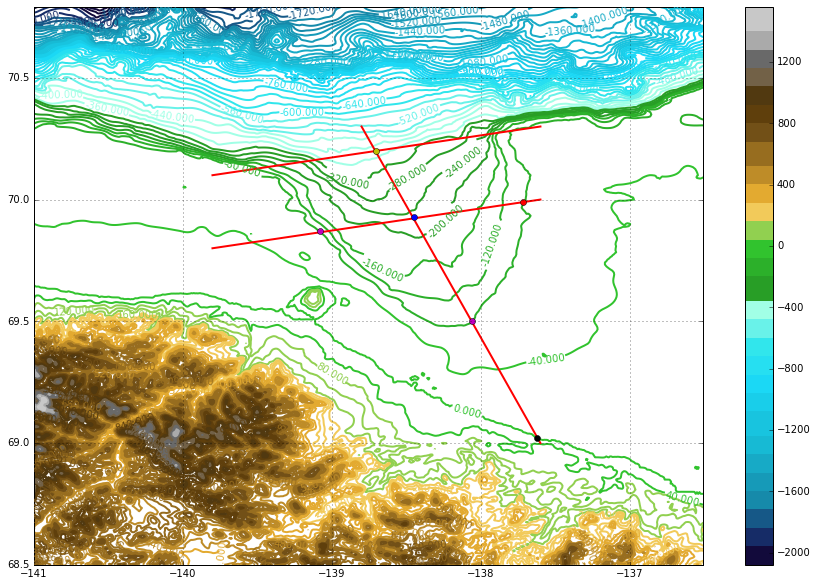

In [152]:
fig, ax = plt.subplots(1,1,figsize=(15,10))
(cmap, norm) = Colormap()
xn, yn, zn = return_boundariesG(x, y, z, -141, -136.5, 68.5, 70.8, None)
ax = plot_mackenzie(ax, xn, yn, zn, 'contour')
ax.plot([-137.6, -138.8],[69.0, 70.3], 'r', linewidth=2)
ax.plot([-139.8, -137.6],[70.1, 70.3], 'r', linewidth=2)
ax.plot([-139.8, -137.6],[70.1-0.3, 70.3-0.3], 'r', linewidth=2)
ax.plot(-138.7, 70.2, 'yo')
ax.plot(-138.06, 69.5, 'mo')
ax.plot(-137.62, 69.02, 'ko')

ax.plot(-137.72, 69.99, 'ro')
ax.plot(-138.45, 69.93, 'bo')
ax.plot(-139.08, 69.87, 'mo')
ax.grid()